# Example of openloop gate optimization

### Import and definitions

In [1]:
import numpy as np
import tensorflow as tf
from scipy.linalg import expm

In [2]:
import c3po.control as control
import c3po.component as component
import c3po.generator as generator
import c3po.envelopes as envelopes
import c3po.hamiltonians as hamiltonians

In [3]:
from c3po.model import Model as Mdl
from c3po.simulator import Simulator as Sim
from c3po.optimizer import Optimizer as Opt
from c3po.experiment import Experiment as Exp

In [4]:
from c3po.utils import log_setup
from c3po.tf_utils import tf_limit_gpu_memory, tf_abs, tf_ave, tf_kron
from c3po.qt_utils import basis, xy_basis, perfect_gate

### Specify parameters of the system

In [5]:
# System
qubit_freq1 = 5.805e9 * 2 * np.pi
qubit_anhar1 = -0.217e9 * 2 * np.pi # here  a negative anharmonicity gives a smaller spacing of 1-2 than 0-1
qubit_freq2 = 5.238e9 * 2 * np.pi
qubit_anhar2 = -0.226e9 * 2 * np.pi
g_coupling = 4.22e9 * 2 * np.pi
qubit_lvls = 4

coupling_ham = hamiltonians.int_YY
drive_ham = hamiltonians.y_drive
v_hz_conversion = 1 # this allows you to put voltage as amplitude and it will convert them to Hz
t_final = 26e-9 # length of the gates

env_freq = 0.5 / t_final * 2 * np.pi
carr_freq = qubit_freq1

In [6]:
# Resolutions
sim_res = 250e9
awg_res = 250e9 # this high resolution is needed to simulate the high frequency components in the drive 

In [7]:
# Directory to log into
logdir = log_setup("/tmp/c3logs/")

In [49]:
# Set up the ground state
ket_0 = tf.constant(basis(qubit_lvls, 0), dtype=tf.complex128)

### Create model object that contains information on the Hamiltonians

In [8]:
q1 = component.Qubit(
    name="Q1",
    desc="Qubit 1",
    comment="the higher frequency qubit",
    freq=qubit_freq1,
    anhar=qubit_anhar1,
    hilbert_dim=qubit_lvls
)
drive = component.Drive(
    name="D1",
    desc="Drive line 1, driving both qubits",
    connected=["Q1"],
    hamiltonian=drive_ham
)

chip_elements = [q1, drive]
model = Mdl(chip_elements)

### Create generator object that contains information of the control lines

In [9]:
# Takes parameters and get AWG bin values
awg = generator.AWG(resolution=awg_res, logdir=logdir)
# Reshapes the signal from the AWG samples to the simulation resolution
dig_to_an = generator.Digital_to_Analog(resolution=sim_res)
# Creates the LO signal
lo = generator.LO(resolution=sim_res)
# Mixes LO and AWG signals
mixer = generator.Mixer()
# Transforms signal from a given voltage on the device to Hz (that go in front of the Hamiltonian)
v_to_hz = generator.Volts_to_Hertz(V_to_Hz=v_hz_conversion)

In [10]:
# Pass all of these devices to the generator object that uses them to make signal from parameters
devices = [lo, awg, mixer, v_to_hz, dig_to_an]
gen = generator.Generator(devices)

### Create gates/operations to implement

In [35]:
# Define parameters and bounds of given envelope functions
fsin_params = {
    'amp': 1.0 * np.pi / t_final, # power in Volts (rescaled with v_hz_conversion)
    'amps': 1 / np.arange(1, 10, 2), # relative amplitude of each component
    # you can also just adjust the amps in volts directly and not include amp (it will default to 1)
    'freqs': np.arange(1, 10, 2) * env_freq,
    'xy_angle': 0.0, # this angle makes this envelope mix with the cos of the carrier
}
fsin_bounds = {
    'amp': [0.0, np.pi / t_final],
    'amps': [0.05, 1.5] * 5,
    'freqs': np.arange(0.5, 10, 1) * env_freq,
    'xy_angle': [-np.pi/4, np.pi/4]
}
# Create envelope object, the function is taken from our library in envelopes.py
fsin = control.Envelope(
    name="I_fsin",
    desc="Inphase envelope with 5 sin components",
    params=fsin_params,
    bounds=fsin_bounds,
    shape=envelopes.fourier_sin
)

In [36]:
# Define parameters and bounds of given envelope functions
fcos_params = {
    'amp': 1.0 * np.pi / t_final,
    'amps': np.zeros(5),
    'freqs': np.arange(1, 10, 2) * env_freq,
    'xy_angle': np.pi/2, # this angle makes this envelope mix with the sin of the carrier
}
fcos_bounds = {
    'amp': [0.0, 0.5 * np.pi / t_final],
    'amps': [-1.0, 1.0] * 5,
    'freqs': np.arange(0.5, 10, 1) * env_freq,
    'xy_angle': [np.pi/4, 3*np.pi/4]
}
# Create envelope object, the function is taken from our library in envelopes.py
fcos = control.Envelope(
    name="Q_fcos",
    desc="Quadrature envelope with 5 cos components",
    params=fcos_params,
    bounds=fcos_bounds,
    shape=envelopes.fourier_cos
)

In [37]:
# Define parameters and bounds of the carrier (this will be used by the LO)
carrier_params = {
    'freq': carr_freq
}
carrier_bounds = {
    'freq': [4e9 * 2 * np.pi, 7e9 * 2 * np.pi]
}
# Create carrier object
carr = control.Carrier(
    name="carrier1",
    desc="Frequency of the local oscillator 1",
    params=carrier_params,
    bounds=carrier_bounds
)

In [38]:
# Create Gate/operation and pass envelopes and carrier

### Single qubit rotation for qubit 1
Y90p_Q1 = control.Instruction(
    name="Y90p_Q1",
    desc="pi/2 rotation around Y for qubit1",
    t_start=0.0,
    t_end=t_final,
    channels=["D1"]
)
Y90p_Q1.add_component(fsin, "D1")
Y90p_Q1.add_component(fcos, "D1")
Y90p_Q1.add_component(carr, "D1")

In [39]:
# Create gateset object and pass the gate created
gates = control.GateSet()
gates.add_instruction(Y90p_Q1)

### Create experiment class and simulator (this is where the computation of the unitary is done)

In [40]:
# Simulation class and fidelity function
exp = Exp(model, gen)
sim = Sim(exp, gates)

In [41]:
# Introduce a Z rotation of the unitary after the gate to rotate back into the qubit frame
a_q1 = model.ann_opers[model.names.index('Q1')]
VZ = expm(1.0j * np.matmul(a_q1.T.conj(), a_q1) * qubit_freq1 * t_final)
sim.VZ = VZ

### Create optimizer object

In [42]:
# Optimizer object
opt = Opt(data_path=logdir)

In [43]:
# Define the map of which parameters will be optimized. The rest will be fixed
opt_map = [
#      [('Y90p_Q1', 'D1', 'I_fsin', 'amp')],
#      [('Y90p_Q1', 'D1', 'Q_fcos', 'amp')],
     [('Y90p_Q1', 'D1', 'I_fsin', 'amps')],
     [('Y90p_Q1', 'D1', 'Q_fcos', 'amps')],
]
# in this case we will only optimize the X90p operation on Q1

In [44]:
# Define states & unitaries
Y90p_ideal = tf.constant(perfect_gate(qubit_lvls, 'Y90p', proj='compsub'), dtype=tf.complex128)

In [46]:
def unitary_infid(U_dict: dict):
    U = U_dict['Y90p_Q1'][0:2,0:2]
    unit_fid = tf_abs(
                tf.linalg.trace(
                    tf.matmul(U, tf.linalg.adjoint(Y90p_ideal))
                    ) / 2
                )**2
    infid = 1 - unit_fid
    return infid

/home/users/froy/Documents/PHD/c3po/c3po/simulator.py:98: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


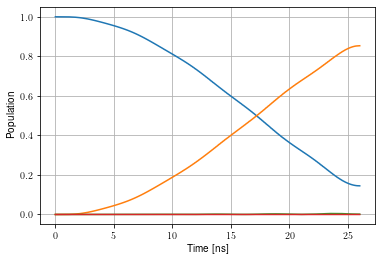

In [50]:
U_dict = sim.get_gates(params, opt_map)
U = U_dict['Y90p_Q1']
sim.plot_dynamics(ket_0)

In [47]:
with tf.device('/CPU:0'):
    opt.optimize_controls(
        sim=sim,
        opt_map=opt_map,
        opt='lbfgs',
        opt_name='openloop',
        fid_func=unitary_infid
    )

Saving as:
/tmp/c3logs/2019_12_02_T_17_12_40/openloop.log


In [24]:
gates.instructions['Y90p_Q1'].comps['D1']['I_fsin'].params

{'amp': 0.0,
 'amps': array([1.        , 0.33333333, 0.2       , 0.14285714, 0.11111111]),
 'freqs': array([1.20830487e+08, 3.62491460e+08, 6.04152433e+08, 8.45813407e+08,
        1.08747438e+09]),
 'xy_angle': 0.0,
 'freq_offset': 0.0}

In [25]:
gates.instructions['Y90p_Q1'].comps['D1']['Q_fcos'].params

{'amp': 0.0,
 'amps': array([0., 0., 0., 0., 0.]),
 'freqs': array([1.20830487e+08, 3.62491460e+08, 6.04152433e+08, 8.45813407e+08,
        1.08747438e+09]),
 'xy_angle': 1.5707963267948966,
 'freq_offset': 0.0}

In [26]:
#Check unitary
params, _ = gates.get_parameters(opt_map)
U_dict = sim.get_gates(params, opt_map)
U = U_dict['Y90p_Q1']

In [27]:
angles = np.angle(np.diag(U.numpy()))
angles

array([ 0.00000000e+00, -1.05579164e-13, -2.24938034e+00, -4.64955713e-01])

In [28]:
angles + np.angle(np.diag(VZ))

array([ 0.        , -0.43982297, -3.12902628, -1.78442463])

In [29]:
sim.VZ

array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.90482705-0.42577929j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.63742399-0.77051324j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.24868989-0.96858316j]])

In [30]:
import qutip as qt

In [31]:
U = U_dict['Y90p_Q1']
U

<tf.Tensor: id=488803, shape=(4, 4), dtype=complex128, numpy=
array([[ 1.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  1.        -1.05579164e-13j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
        -0.62769136-7.78462302e-01j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.89384142-4.48383216e-01j]])>

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ef9902e2130>)

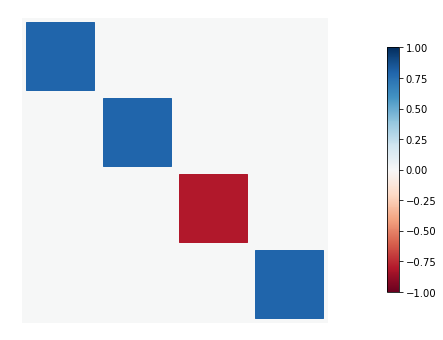

In [32]:
qt.hinton(U_dict['Y90p_Q1'].numpy())

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ef963fdcee0>)

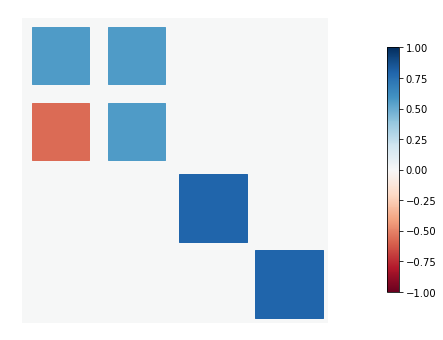

In [33]:
Y90p_ideal = tf.constant(perfect_gate(qubit_lvls, 'Y90p', proj='fulluni'), dtype=tf.complex128)
qt.hinton(Y90p_ideal.numpy())

# Plotting

You can run the code below in a different kernel to get a live plot. Or look a the log e.g.

$ less +F /tmp/c3logs/recent/openloop.log

In [34]:
from c3po.display import plot_OC_logs
plot_OC_logs("/tmp/c3logs/recent/openloop.log")